In [11]:
%matplotlib inline

## Pain image-based meta-analysis with NIDM-Results

This notebook demonstrate how to perform a group image-based meta-analysis on the effect of pain using datasets available on [NeuroVault (collection 1425)](http://neurovault.org/collections/1425/).


In [2]:
import os
from rdflib.graph import Graph
from rdflib.term import URIRef
from subprocess import check_call
from rdflib.graph import Graph
from nidmresults.objects.constants import SCR_FSL, SCR_SPM
import collections
import glob
import zipfile
import json
from urllib2 import urlopen, URLError, HTTPError
from urllib2 import Request

In [26]:
pwd = os.path.dirname(os.path.realpath('__file__'))
input_dir = os.path.join(pwd, "input")
data_dir = os.path.join(input_dir, "data")
pain_dir = os.path.join(data_dir, "pain")

out_dir = os.path.join(pwd, "output", "IBMA", "data")

### Download NIDM-Results packs from NeuroVault

 - Query NeuroVault's API to retreive all NIDM packs in collection 1425
 - Download and save the packs in sub-folder `input/data` 

In [18]:
request = Request('http://neurovault.org/api/collections/1425/nidm_results/?limit=184&format=json')
response = urlopen(request)
elevations = response.read()
data = json.loads(elevations)

if not os.path.isdir(pain_dir):
    if not os.path.isdir(data_dir):
        if not os.path.isdir(input_dir):
            os.makedirs(input_dir)
        os.makedirs(data_dir)
    os.makedirs(pain_dir)

for nidm_result in data["results"]:
    url = nidm_result["zip_file"]
    study_name = nidm_result["name"]
    
    localzip = os.path.join(pain_dir, study_name + ".zip")
    localzip_rel = localzip.replace(pwd, '.')
    if not os.path.isfile(localzip):
        # Copy .nidm.zip export locally in a the data directory
        try:
            f = urlopen(url)
            print("downloading " + url + " at " + localzip_rel)
            with open(localzip, "wb") as local_file:
                local_file.write(f.read())
        except HTTPError, e:
            raise Exception(["HTTP Error:" + e.code + url])
        except URLError, e:
            raise Exception(["URL Error:" + e.reason + url])
    else:
        print(url + " already downloaded at " + localzip_rel)

http://neurovault.org/collections/1425/pain_01.nidm.zip already downloaded at ./input/data/pain/pain_01.nidm.zip
http://neurovault.org/collections/1425/pain_02.nidm.zip already downloaded at ./input/data/pain/pain_02.nidm.zip
http://neurovault.org/collections/1425/pain_03.nidm.zip already downloaded at ./input/data/pain/pain_03.nidm.zip
http://neurovault.org/collections/1425/pain_04.nidm.zip already downloaded at ./input/data/pain/pain_04.nidm.zip
http://neurovault.org/collections/1425/pain_05.nidm.zip already downloaded at ./input/data/pain/pain_05.nidm.zip
http://neurovault.org/collections/1425/pain_06.nidm.zip already downloaded at ./input/data/pain/pain_06.nidm.zip
http://neurovault.org/collections/1425/pain_07.nidm.zip already downloaded at ./input/data/pain/pain_07.nidm.zip
http://neurovault.org/collections/1425/pain_08.nidm.zip already downloaded at ./input/data/pain/pain_08.nidm.zip
http://neurovault.org/collections/1425/pain_09.nidm.zip already downloaded at ./input/data/pain/

In [28]:
studies = glob.glob(os.path.join(pain_dir, '*.nidm.zip'))

studies = studies[0:1]
print(studies)

for nidm_file in studies:
    g = ni.graph.Graph(nidm_file)
    print(g)
    print(g.get_contrast_maps())



['/Users/cmaumet/Projects/Data_sharing/dev/nidmresults-paper/input/data/pain/pain_01.nidm.zip']
<nidmresults.graph.Graph instance at 0x107410d40>


AttributeError: Graph instance has no attribute 'get_contrast_maps'

In [34]:
studies = glob.glob(os.path.join(pain_dir, '*.nidm.zip'))

FSL_DESIGN_DIR = os.path.join(pwd, "input", "IBMA", "fsl_design")
assert os.path.isdir(FSL_DESIGN_DIR)

if not os.path.exists(out_dir):
    os.makedirs(out_dir)


con_maps = dict()
varcon_maps = dict()
mask_maps = dict()
out
ma_mask_name = os.path.join(out_dir, "mask_ma")
ma_mask = None

for nidm_file in studies:
    study = os.path.basename(nidm_file.replace(".nidm.zip", ""))
    nidm_dir = os.path.join(out_dir, "pre", study)
    print "\nStudy: " + study

    with zipfile.ZipFile(nidm_file) as z:
        if not os.path.exists(nidm_dir):
            os.makedirs(nidm_dir)
        z.extractall(nidm_dir)

    nidm_doc = os.path.join(nidm_dir, "nidm.ttl")
    assert os.path.isfile(nidm_doc)

    nidm_graph = Graph()
    nidm_graph.parse(nidm_doc, format='turtle')

    query = """
    prefix prov: <http://www.w3.org/ns/prov#>
    prefix nidm: <http://purl.org/nidash/nidm#>

    prefix contrast_estimation: <http://purl.org/nidash/nidm#NIDM_0000001>
    prefix contrast_map: <http://purl.org/nidash/nidm#NIDM_0000002>
    prefix stderr_map: <http://purl.org/nidash/nidm#NIDM_0000013>
    prefix contrast_name: <http://purl.org/nidash/nidm#NIDM_0000085>
    prefix statistic_map: <http://purl.org/nidash/nidm#NIDM_0000076>
    prefix mask_map: <http://purl.org/nidash/nidm#NIDM_0000054>

    SELECT ?contrastName ?con_file ?std_file
    ?mask_file ?software WHERE {
     ?con_id a contrast_map: ;
          contrast_name: ?contrastName ;
          prov:atLocation ?con_file ;
          prov:wasGeneratedBy ?con_est .
     ?std_id a stderr_map: ;
          prov:atLocation ?std_file ;
          prov:wasGeneratedBy ?con_est .
     ?mask_id a mask_map: ;
          prov:atLocation ?mask_file .
     ?soft_id a ?software .
     ?con_est a contrast_estimation: ;
              prov:wasAssociatedWith ?soft_id ;
              prov:used ?mask_id .

      FILTER(?software NOT IN (
        prov:SoftwareAgent, prov:Agent))
    }

    """
    sd = nidm_graph.query(query)

    if sd:
        for row in sd:
            con_name, con_file, std_file, mask_file, software = row
            con_file = os.path.join(nidm_dir, con_file)
            std_file = os.path.join(nidm_dir, std_file)
            mask_file = os.path.join(nidm_dir, mask_file)

            if str(con_name) == "pain":
                if software == URIRef(SCR_SPM.uri):
                    print "--> analyzed with SPM"
                    # If study was performed with SPM, reslice to FSL's
                    # template space
                    for to_reslice in [con_file, std_file, mask_file]:
                        file_name = os.path.basename(
                            to_reslice).split(".")[0]
                        resliced_file = os.path.join(
                            out_dir, study + "_" + file_name + "_r")
                        cmd = [
                            "cd \"" + nidm_dir + "\";" +
                            " flirt -in " + file_name + " -ref " +
                            "$FSLDIR/data/standard/MNI152_T1_2mm " +
                            "-applyxfm -usesqform " +
                            "-out " + resliced_file
                            ]
                        print "Running " + ",".join(cmd)
                        check_call(cmd, shell=True)

                        if to_reslice == mask_file:
                            mask_file = resliced_file
                        elif to_reslice == con_file:
                            con_maps[study] = resliced_file
                        elif to_reslice == std_file:
                            std_file = resliced_file

                elif software == URIRef(SCR_FSL.uri):
                    print "--> analyzed with FSL"
                    # If study was performed with FSL, rescale to a target
                    # value of 100
                    for to_rescale in [con_file, std_file]:
                        file_name = os.path.basename(
                            to_rescale).split(".")[0]
                        rescaled_file = os.path.join(
                            out_dir, study + "_" + file_name + "_s")
                        cmd = [
                            "cd \"" + nidm_dir + "\";" +
                            " fslmaths \"" + file_name + "\" -div 100 " +
                            " \"" + rescaled_file + "\""
                            ]
                        print "Running " + ",".join(cmd)
                        check_call(cmd, shell=True)

                        if to_rescale == con_file:
                            con_maps[study] = "\"" + rescaled_file + "\""
                        elif to_rescale == std_file:
                            std_file = "\"" + rescaled_file + "\""

                    mask_file = mask_file.replace("file://.", nidm_dir)

                else:
                    raise Exception(
                        'Unknown neuroimaging software: ' + str(software))

                # Create varcope from standard error map
                varcope_file = "\"" + \
                               os.path.join(out_dir, study + "_varcope") +\
                               "\""
                cmd = [" fslmaths " + std_file + " -sqr " + varcope_file]
                print "Running " + ",".join(cmd)
                check_call(cmd, shell=True)

                varcon_maps[study] = varcope_file

                # Compute meta-analysis mask as the intersection of all
                # study analysis masks
                if ma_mask is None:
                    ma_mask = mask_file
                else:
                    cmd = [
                        " fslmaths \"" + mask_file + "\" -min " +
                        "\"" + ma_mask + "\" \"" + ma_mask_name + "\""
                        ]
                    print "Running " + ",".join(cmd)
                    check_call(cmd, shell=True)
                    ma_mask = ma_mask_name
            else:
                print "Ignore contrast '" + str(con_name) + "'."

    else:
        print "Query returned no results for study "+study+"."

# Binarize the analysis mask
cmd = ["fslmaths \"" + ma_mask + "\" -thr 0.9 -bin \"" + ma_mask + "\""]
print "Running " + ",".join(cmd)
check_call(cmd, shell=True)

# Sort copes and varcopes by study names
to_merge = {'copes': collections.OrderedDict(sorted(con_maps.items())),
            'varcopes': collections.OrderedDict(
                sorted(varcon_maps.items()))}
for file_name, files in to_merge.items():
    cmd = [
        "fslmerge -t \""+os.path.join(out_dir, file_name) +
        ".nii.gz\" "+" ".join(files.values())
    ]
    print "Running " + ",".join(cmd)
    check_call(cmd, shell=True)

# Remove NaNs from copes and varcopes
# (SPM code background with NaNs while FSL uses zeros)
cmd = ["cd " + out_dir + "; fslmaths copes.nii.gz -nan copes"]
print "Running " + ",".join(cmd)
check_call(cmd, shell=True)

cmd = ["cd " + out_dir + "; fslmaths varcopes.nii.gz -nan varcopes"]
print "Running " + ",".join(cmd)
check_call(cmd, shell=True)

# Mixed-effects GLM (study-level)
cmd = [
    "cd " + out_dir + "; flameo --cope=copes --vc=varcopes --ld=stats "
    " --dm=" + os.path.join(FSL_DESIGN_DIR, "simple_meta_analysis.mat") +
    " --cs=" + os.path.join(FSL_DESIGN_DIR, "simple_meta_analysis.grp") +
    " --tc=" + os.path.join(FSL_DESIGN_DIR, "simple_meta_analysis.con ") +
    " --mask=\""+ma_mask_name+"\" --runmode=flame1"]
print "Running " + ",".join(cmd)
check_call(cmd, shell=True)

stat_dir = os.path.join(out_dir, "stats")

# FWE Voxel-wise corrected threshold p<0.05 (with a cluster forming
# threshold of p<0.001 uncorrected)
# Scripts from http://blogs.warwick.ac.uk/nichols/entry/flame_without_1st/
cmd = [
    "cd " + out_dir + "; " +
    "echo $($FSLDIR/bin/fslnvols copes) - 1 | bc -l  > stats/dof ;" +
    "/bin/rm -f stats/zem* stats/zols* stats/mask* ;" +
    "$FSLDIR/bin/smoothest -d $(cat stats/dof) -m " + ma_mask_name +
    " -r stats/res4d > stats/smoothness ;" +
    "awk '/VOLUME/ {print $2}' stats/smoothness > thresh_zstat1.vol ;" +
    "awk '/DLH/ {print $2}' stats/smoothness > thresh_zstat1.dlh ;" +
    "$FSLDIR/bin/fslmaths stats/zstat1 -mas " + ma_mask_name +
    " thresh_zstat1;" +
    "$FSLDIR/bin/cluster -i thresh_zstat1 -c stats/cope1 -t 3.1 -p 0.05" +
    " -d $(cat thresh_zstat1.dlh) --volume=$(cat thresh_zstat1.vol) " +
    "--othresh=thresh_zstat1 -o cluster_mask_zstat1 --connectivity=26 " +
    "--mm --olmax=lmax_zstat1_tal.txt > cluster_zstat1_std.txt;" +
    "$FSLDIR/bin/cluster2html . cluster_zstat1 -std;" +
    "MinMax=$($FSLDIR/bin/fslstats thresh_zstat1 -l 0.0001 -R);" +
    "$FSLDIR/bin/overlay 1 0 $FSLDIR/data/standard/MNI152_T1_2mm.nii.gz " +
    "-a thresh_zstat1 $MinMax " +
    "rendered_thresh_zstat1;" +
    "$FSLDIR/bin/slicer rendered_thresh_zstat1 -S 2 750 " +
    "rendered_thresh_zstat1.png;" +
    "cp $FSLDIR/etc/luts/ramp.gif .ramp.gif"
]
print "Running " + ",".join(cmd)
check_call(cmd, shell=True)



Study: pain_01
--> analyzed with SPM
Running cd "/Users/cmaumet/Projects/Data_sharing/dev/nidmresults-paper/output/IBMA/data/pre/pain_01"; flirt -in Contrast -ref $FSLDIR/data/standard/MNI152_T1_2mm -applyxfm -usesqform -out /Users/cmaumet/Projects/Data_sharing/dev/nidmresults-paper/output/IBMA/data/pain_01_Contrast_r
Running cd "/Users/cmaumet/Projects/Data_sharing/dev/nidmresults-paper/output/IBMA/data/pre/pain_01"; flirt -in ContrastStandardError -ref $FSLDIR/data/standard/MNI152_T1_2mm -applyxfm -usesqform -out /Users/cmaumet/Projects/Data_sharing/dev/nidmresults-paper/output/IBMA/data/pain_01_ContrastStandardError_r
Running cd "/Users/cmaumet/Projects/Data_sharing/dev/nidmresults-paper/output/IBMA/data/pre/pain_01"; flirt -in Mask -ref $FSLDIR/data/standard/MNI152_T1_2mm -applyxfm -usesqform -out /Users/cmaumet/Projects/Data_sharing/dev/nidmresults-paper/output/IBMA/data/pain_01_Mask_r
Running  fslmaths /Users/cmaumet/Projects/Data_sharing/dev/nidmresults-paper/output/IBMA/data/p

0

In [27]:
print(os.listdir(out_dir))
ibma_thresh_img = os.path.join(out_dir, 'thresh_zstat1.nii.gz')

['.DS_Store', '.ramp.gif', 'cluster_mask_zstat1.nii.gz', 'cluster_zstat1_std.html', 'cluster_zstat1_std.txt', 'copes.nii.gz', 'lmax_zstat1_tal.txt', 'mask_ma.nii.gz', 'NeuroVault', 'pain_01_Contrast_r.nii.gz', 'pain_01_ContrastStandardError_r.nii.gz', 'pain_01_Mask_r.nii.gz', 'pain_01_varcope.nii.gz', 'pain_02_Contrast_r.nii.gz', 'pain_02_ContrastStandardError_r.nii.gz', 'pain_02_Mask_r.nii.gz', 'pain_02_varcope.nii.gz', 'pain_03_Contrast_r.nii.gz', 'pain_03_ContrastStandardError_r.nii.gz', 'pain_03_Mask_r.nii.gz', 'pain_03_varcope.nii.gz', 'pain_04_Contrast_r.nii.gz', 'pain_04_ContrastStandardError_r.nii.gz', 'pain_04_Mask_r.nii.gz', 'pain_04_varcope.nii.gz', 'pain_05_Contrast_r.nii.gz', 'pain_05_ContrastStandardError_r.nii.gz', 'pain_05_Mask_r.nii.gz', 'pain_05_varcope.nii.gz', 'pain_06_Contrast_r.nii.gz', 'pain_06_ContrastStandardError_r.nii.gz', 'pain_06_Mask_r.nii.gz', 'pain_06_varcope.nii.gz', 'pain_07_Contrast_r.nii.gz', 'pain_07_ContrastStandardError_r.nii.gz', 'pain_07_Mask_r.

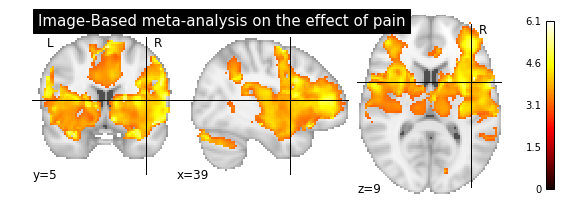

In [40]:


from nilearn import plotting

plotting.plot_stat_map(ibma_thresh_img, display_mode='ortho', title='Image-Based meta-analysis on the effect of pain')

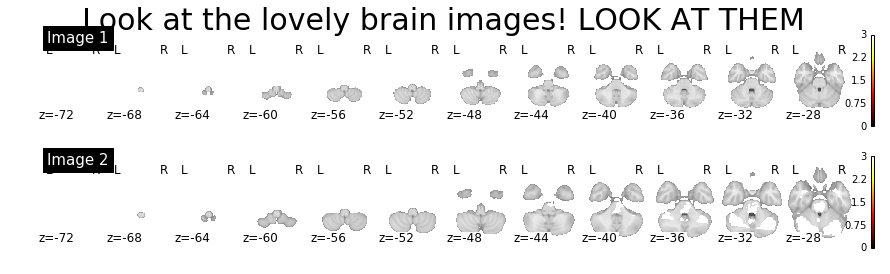

In [34]:
plotting.plot_stat_map(cbma_thresh_img, 
                       display_mode='ortho', 
                       title='Coordinate-Based meta-analysis on the effect of pain',
                       cut_coords=(40,39,9))

In [41]:
cbma_thresh_img = out_dir = os.path.join(pwd, "output", "CBMA", "pain_contrast", "Activation_FWE_extent.nii")

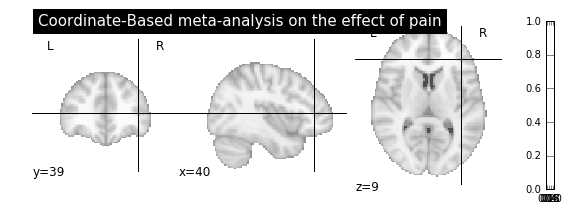

In [42]:
plotting.plot_stat_map(cbma_thresh_img, 
                       display_mode='ortho', 
                       title='Coordinate-Based meta-analysis on the effect of pain',
                       cut_coords=(40,39,9))